In [7]:
import pandas as pd
import numpy as np
import seaborn as sns


In [3]:
habi_df = pd.read_excel('dataset.xlsx')

In [5]:
habi_df.head()

,id,birth_date,terms_conditions,gender,meta,date_exp_token,id.1,contact_id,type_occupation_id,type_independent_activity_id,...,company_phone,company_city_id,name,label,is_active,activity_code,name.1,label.1,viability,is_selected
0,1767,1998-05-30,1,NaN,NaN,2022-11-25 23:13:29.0,5,1767,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,0
1,1767,1998-05-30,1,NaN,NaN,2022-11-25 23:13:29.0,5,1767,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,0,0
2,23963,1984-07-08,0,NaN,NaN,2023-01-16 18:16:50.0,4547,23963,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
3,23965,1985-02-14,0,NaN,NaN,NaN,4549,23965,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
4,24370,1997-01-09,0,NaN,NaN,NaN,4860,24370,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1


<Axes: >

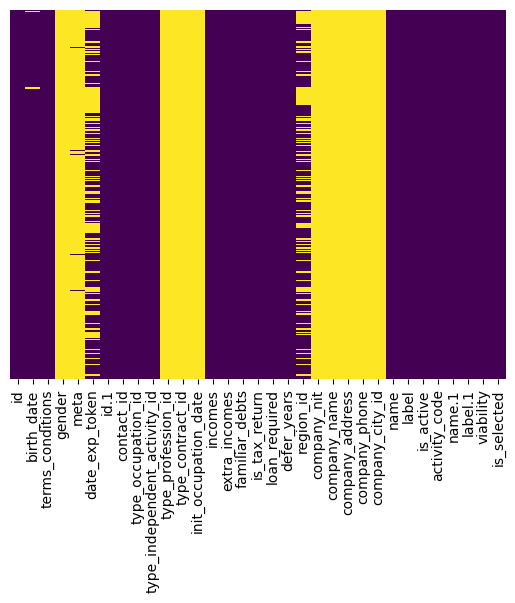

In [8]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

No son utiles: 
gender
meta
type_profession_id
type_contract_id
init_occupation_date
company_nit
company_name
company_address
company_phone
company_city_id

In [17]:
habi_df.columns

Index(['id', 'birth_date', 'terms_conditions', 'date_exp_token', 'id.1',
       'contact_id', 'type_occupation_id', 'type_independent_activity_id',
       'incomes', 'extra_incomes', 'familiar_debts', 'is_tax_return',
       'loan_required', 'defer_years', 'region_id', 'name', 'label',
       'is_active', 'activity_code', 'name.1', 'label.1', 'viability',
       'is_selected'],
      dtype='object')

In [10]:
habi_df = habi_df.drop(columns=["gender",
    "meta",
    "type_profession_id",
    "type_contract_id",
    "init_occupation_date",
    "company_nit",
    "company_name",
    "company_address",
    "company_phone",
    "company_city_id"
    ]
)

<Axes: >

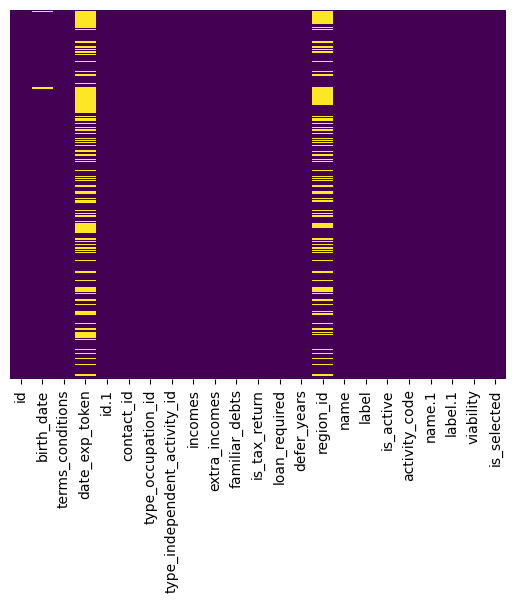

In [11]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [19]:
habi_df['viability'].value_counts()

viability
1    2698
0    1246
Name: count, dtype: int64

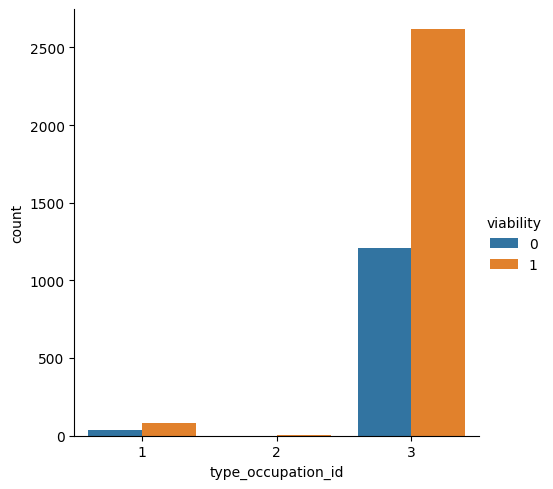

In [16]:
sns.catplot(x='type_occupation_id',hue='viability',data=habi_df,kind="count")

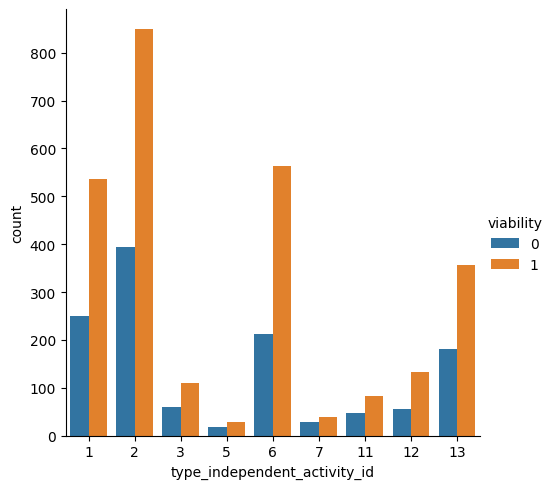

In [18]:
sns.catplot(x='type_independent_activity_id',hue='viability',data=habi_df,kind="count")

<Axes: xlabel='type_independent_activity_id'>

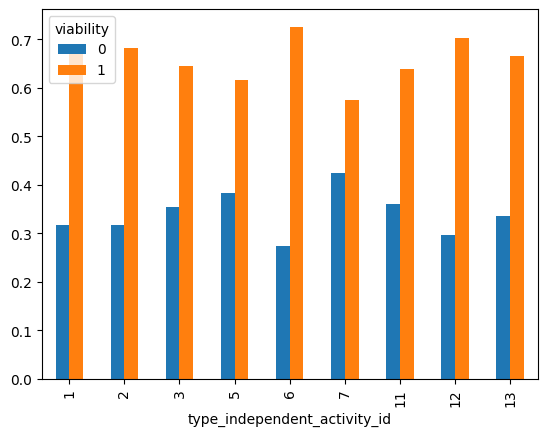

In [31]:
probabilities = habi_df.groupby(['type_independent_activity_id', 'viability']).size() / habi_df.groupby('type_independent_activity_id').size()
probabilities = probabilities.reset_index().rename(columns={0: 'Probability'})
pivot_df = probabilities.pivot(index='type_independent_activity_id', columns='viability', values='Probability')

pivot_df.plot(kind='bar', stacked=False)


In [32]:
pivot_df

viability,0,1
type_independent_activity_id,,
1,0.317197,0.682803
2,0.317524,0.682476
3,0.355030,0.644970
5,0.382979,0.617021
6,0.274131,0.725869
7,0.424242,0.575758
11,0.361538,0.638462
12,0.296296,0.703704
13,0.335196,0.664804


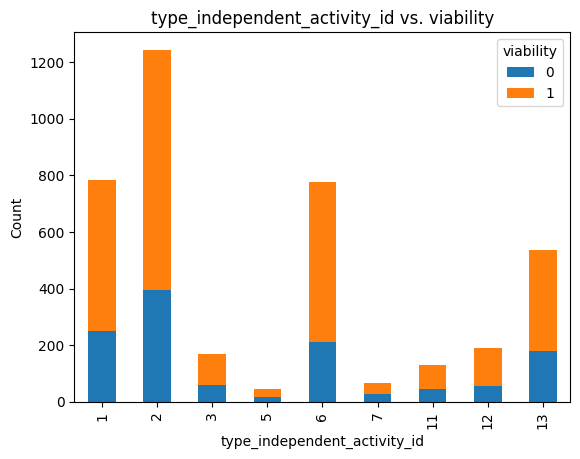

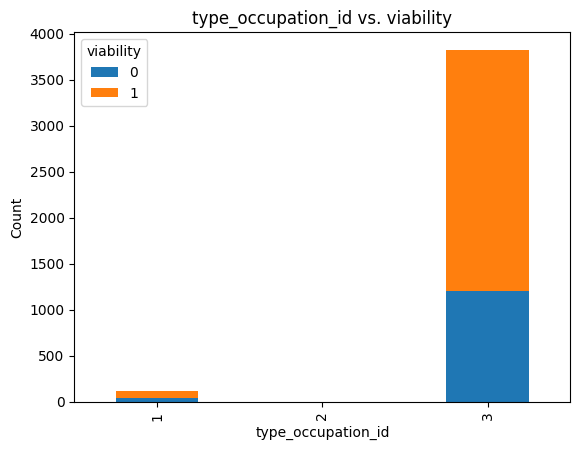

In [20]:
import matplotlib.pyplot as plt

# Identify the target variable and categorical variables you want to compare
target_variable = 'viability'
categorical_variables = ['type_independent_activity_id','type_occupation_id']

# Iterate over each categorical variable
for cat_var in categorical_variables:
    # Create a cross-tabulation between the categorical variable and the target variable
    cross_tab = pd.crosstab(habi_df[cat_var], habi_df[target_variable])

    # Plot a stacked bar chart
    cross_tab.plot(kind='bar', stacked=True)
    plt.title(f'{cat_var} vs. {target_variable}')
    plt.xlabel(cat_var)
    plt.ylabel('Count')
    plt.legend(title=target_variable)
    plt.show()